In [1]:
%matplotlib inline

from collections import defaultdict
import random 
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import tqdm 

In [2]:
class State:
    SUM = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
    CARDS = ['Ace', 2, 3, 4, 5, 6, 7, 8, 9, 10]
    CARDS_TO_DRAW = ['Ace', 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
    
    @staticmethod
    def n_states():
        return len(State.SUM) * len(State.CARDS)
    
    @staticmethod
    def id_to_state(index: int):
        id1 = index // 10
        id2 = index % 10
        return State.SUM[id1], State.CARDS[id2]
    
    @staticmethod
    def state_to_id(state: Tuple[int, Union[int, int]]):
        id1 = State.SUM.index(state[0])
        id2 = State.CARDS.index(state[1])
        return id1 * 10 + id2

In [3]:
def sample_action(policy, state_id: int) -> int:
    return np.random.choice([0, 1], p=policy[state_id])

In [4]:
class Environment:
    HIT_ACTION = 0
    STICK_ACTION = 1
    ACTIONS = (HIT_ACTION, STICK_ACTION)
    
    # current_state, action -> next_state, potential return if game is over
    def do_action(self, state_id, action) -> Tuple[Optional[State], Optional[int]]:
        state = State.id_to_state(state_id)
        if action == self.HIT_ACTION:
            new_card = self._draw_card()
            new_sum = self._get_new_sum(state[0], new_card)
            if new_sum > 21:
                return None, -1
            
            return State.state_to_id((new_sum, state[1])), None
        
        elif action == self.STICK_ACTION:
            dealer_sum = state[1] if state[1] != 'Ace' else 11
            blackjack = state[0] == 21
            while dealer_sum < 17:
                dealer_sum = self._get_new_sum(dealer_sum, self._draw_card())
                if dealer_sum != 21 and blackjack:
                    return None, 1
                
            if dealer_sum > 21:
                return None, 1

            if state[0] == dealer_sum:
                return None, 0
            elif state[0] > dealer_sum:
                return None, 1 
            else:
                return None, -1 
            
    def _draw_card(self) -> Union[int, str]:
        return random.choice(State.CARDS)
            
    def _get_new_sum(self, current_sum, card) -> int:
        if card == 'Ace':
            if current_sum + 11 <= 21:
                return current_sum + 11
            else:
                return current_sum + 1
        return current_sum + card 

    def generate_random_state(self) -> int:
        return np.random.choice(np.arange(State.n_states()))
    
    def num_actions(self) -> int:
        return len(self.ACTIONS)
    
    def num_states(self) -> int:
        return State.n_states()

In [5]:
def run_episode(
    env: Environment,
    policy: np.ndarray
) -> Tuple[List[Tuple[int, int]], int]:
    
    episode_finished = False
    state_id = env.generate_random_state()
    trajectory = []
    
    while True:
        action = sample_action(policy, state_id) 
        next_state_id, r = env.do_action(state_id, action)
        trajectory.append((state_id, action))
        
        if r is not None:
            return trajectory, r
        state_id = next_state_id

In [6]:
def mc_soft_epsilon(
    env: Environment,
    epsilon: float,
    n_iter: int,
):
    N = np.ones((env.num_states(), env.num_actions()))
    Q = np.zeros((env.num_states(), env.num_actions()))
    
    policy = np.ones((env.num_states(), env.num_actions())) / env.num_actions()
    
    for i in tqdm.tqdm(range(n_iter)):
        trajectory, r = run_episode(env, policy)
        visited_states = []
        
        for state_id, action in trajectory:
            N[state_id, action] += 1
            Q[state_id, action] += r
            visited_states.append(state_id)
        
        visited_states = set(visited_states)
        
        for state_id in visited_states:
            temp = Q[state_id] / N[state_id]
            policy[state_id] = epsilon
            policy[state_id, np.argmax(temp)] = 1 - epsilon
    
    return (Q / N).argmax(axis=1)

In [7]:
optimal_policy = mc_soft_epsilon(Environment(), 0.05, 10000000)

100%|██████████| 10000000/10000000 [09:30<00:00, 17539.45it/s]


In [8]:
x = []
y = []
actions = []

for s in State.SUM:
    for c in State.CARDS:
        x.append(c if c != 'Ace' else 11)
        y.append(s)
        actions.append(optimal_policy[State.state_to_id((s, c))])

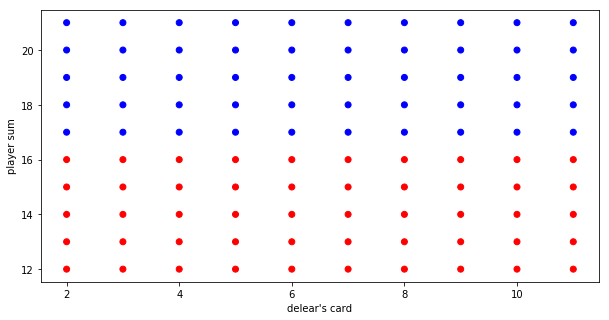

In [9]:
_, _ = plt.subplots(figsize=(10, 5)) 
plt.scatter(x, 
            y, 
            color=np.where(np.array(actions) == Environment.HIT_ACTION, 'red', 'blue'))
plt.xlabel("delear's card")
plt.ylabel('player sum');